# Wrangling behavorial data generated by OpenSesame


## Introduction
You build the experiment and ran your first participant. Now, it is time to take a look at the data you have collected.

OpenSesame outputs a *comma-separated values (csv)* file. This is a very widely used format, and you can painlessly import this file type in Python using the datafile package **pandas**. Let's import a datafile from two participants and merge those in one file:



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

subj1 = pd.read_csv("data/subject-1.csv", sep=",")
subj2 = pd.read_csv("data/subject-2.csv", sep=",")

df = pd.concat([subj1, subj2], ignore_index=True)
df

,EEG,ET,acc,accuracy,average_response_time,avg_rt,background,baseline_measurement,bidi,block,...,time_trial_sequence_prac_paritymagnitude,time_white_baseline,time_wrong_response_feedback,title,total_correct,total_response_time,total_responses,trialnr,uniform_coordinates,width
0,1,1,100.000000,100.000000,929.279800,929.279800,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,1,9.292798e+02,1,1,yes,1680
1,1,1,100.000000,100.000000,760.166800,760.166800,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,2,1.520334e+03,2,2,yes,1680
2,1,1,100.000000,100.000000,681.195000,681.195000,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,3,2.043585e+03,3,3,yes,1680
3,1,1,75.000000,75.000000,881.623825,881.623825,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,3,3.526495e+03,4,4,yes,1680
4,1,1,80.000000,80.000000,869.731600,869.731600,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,4,4.348658e+03,5,5,yes,1680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,1,92.184369,92.184369,2187.341999,2187.341999,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,460,1.091484e+06,499,61,yes,1680
948,1,1,92.200000,92.200000,2183.888454,2183.888454,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,461,1.091944e+06,500,62,yes,1680
949,1,1,92.215569,92.215569,2180.879513,2180.879513,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,462,1.092621e+06,501,63,yes,1680
950,1,1,92.231076,92.231076,2177.548002,2177.548002,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,463,1.093129e+06,502,64,yes,1680


That's a lot of columns. In your "logger" file in OpenSesame, the recommended thing to do is to check the box of "Log all variables". This is the safest option, because it's easy to remove columns and you would rather not have that you missed an essential variable after doing your experiment. Let's pick the columns that we need:


In [2]:
include_columns = ['subject_nr', 'block', 'congruency_transition_type', 'congruency_type',
                   'correct', 'response_time', 'task_transition_type', 'task_type']

df_trim = df[include_columns]
df_trim

,subject_nr,block,congruency_transition_type,congruency_type,correct,response_time,task_transition_type,task_type
0,1,1,NaN,congruent,1,929.2798,NaN,parity
1,1,1,congruency-repetition,congruent,1,591.0538,task-repetition,parity
2,1,1,congruency-repetition,congruent,1,523.2514,task-repetition,parity
3,1,1,congruency-switch,incongruent,0,1482.9103,task-repetition,parity
4,1,1,congruency-switch,congruent,1,822.1627,task-repetition,parity
...,...,...,...,...,...,...,...,...
947,2,12,congruency-repetition,incongruent,1,551.2024,task-switch,parity
948,2,12,congruency-switch,congruent,1,460.5698,task-repetition,parity
949,2,12,congruency-repetition,congruent,1,676.4091,task-switch,magnitude
950,2,12,congruency-repetition,congruent,1,508.4610,task-repetition,magnitude


Alright, it's getting a bit more uncluttered now. The task-design is so that the last two blocks are different kind of blocks. We don't have to go in details now, but for further analysis we will have to create a dataframe without block 11 and 12. There are [many ways to conditional selection of rows](https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/), but here we opt to use the information that we need all blocks with a value smaller than 11.

In [3]:
# Here the last blocks should be 12
print(df_trim.tail(5))

# Conditionally select rows based on if the value in the "block" column is lower than 11
df_trim_blocks = df_trim[df_trim['block'] < 11]

# Check to see if the last block is now 10 instead of 12
print(df_trim_blocks.tail(5))

     subject_nr  block congruency_transition_type congruency_type  correct  \
947           2     12      congruency-repetition     incongruent        1   
948           2     12          congruency-switch       congruent        1   
949           2     12      congruency-repetition       congruent        1   
950           2     12      congruency-repetition       congruent        1   
951           2     12      congruency-repetition       congruent        1   

     response_time task_transition_type  task_type  
947       551.2024          task-switch     parity  
948       460.5698      task-repetition     parity  
949       676.4091          task-switch  magnitude  
950       508.4610      task-repetition  magnitude  
951       571.3132      task-repetition  magnitude  
     subject_nr  block congruency_transition_type congruency_type  correct  \
811           2     10          congruency-switch     incongruent        1   
812           2     10          congruency-switch       c

In [4]:
#check counts
pd.pivot_table(
    df_trim,
    values="correct",
    index=["subject_nr"],
    columns=["congruency_type"],
    aggfunc=len,
)

df_trim['task_type'].value_counts()
df_trim['congruency_type'].value_counts()
df_trim['congruency_transition_type'].value_counts()

congruency-repetition    464
congruency-switch        464
Name: congruency_transition_type, dtype: int64

 Let's get a feel wat we are dealing with.

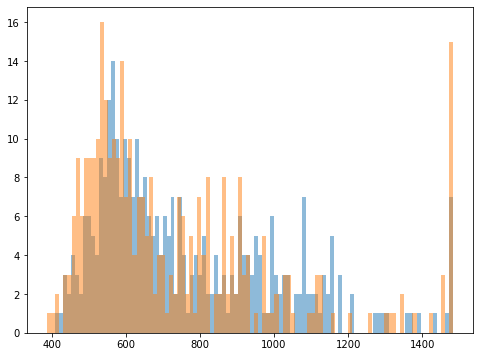

In [5]:
#dataframe syntax
plt.figure(figsize=(8,6));
plt.hist(df_trim_blocks.query("task_transition_type == 'task-switch'").response_time, bins=100, alpha=0.5, label="Task switches");
plt.hist(df_trim_blocks.query("task_transition_type == 'task-repetition'").response_time, bins=100, alpha=0.5, label="Task repetitions");

In [6]:
#df.head()

#df['acc']
#df.acc

#df.iloc[1]

#print(df['congruency'])

#df.shape

#dfg = df.groupby('subject_nr')
#dfg.mean()

#df.groupby('subject_nr').agg([np.sum, np.mean, np.std])


df_trim_blocks['rt_zscore'] = df.groupby(['subject_nr','task_transition_type'])['response_time'].transform(lambda x: (x-x.mean())/x.std())

print(df_trim_blocks)

ValueError: Length mismatch: Expected axis has 928 elements, new values have 952 elements

In [7]:
plt.figure(figsize=(8,6));
plt.hist(df.query("congruency == 'inc' & rt_zscore <= 3").response_time, bins=100, alpha=0.5, label="data1");
plt.hist(df.query("congruency == 'inc' & rt_zscore > 3").response_time, bins=100, alpha=0.5, label="data2");

UndefinedVariableError: name 'congruency' is not defined

<Figure size 576x432 with 0 Axes>

In [8]:
import seaborn as sns

df['is_outlier'] = df['rt_zscore'] > 3

sns.set_theme(style="darkgrid")
sns.displot(
    df.query("subject_nr != 0"), x="response_time", col="congruency", row="subject_nr",
    binwidth=10, height=3, facet_kws=dict(margin_titles=True), hue = "is_outlier",
)

ModuleNotFoundError: No module named 'seaborn'

In [9]:
df

,EEG,ET,acc,accuracy,average_response_time,avg_rt,background,baseline_measurement,bidi,block,...,time_trial_sequence_prac_paritymagnitude,time_white_baseline,time_wrong_response_feedback,title,total_correct,total_response_time,total_responses,trialnr,uniform_coordinates,width
0,1,1,100.000000,100.000000,929.279800,929.279800,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,1,9.292798e+02,1,1,yes,1680
1,1,1,100.000000,100.000000,760.166800,760.166800,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,2,1.520334e+03,2,2,yes,1680
2,1,1,100.000000,100.000000,681.195000,681.195000,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,3,2.043585e+03,3,3,yes,1680
3,1,1,75.000000,75.000000,881.623825,881.623825,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,3,3.526495e+03,4,4,yes,1680
4,1,1,80.000000,80.000000,869.731600,869.731600,#a4b6d9,1,yes,1,...,2.992969e+06,3.099097e+06,2.904703e+06,Parity-magnitude task with teufel colors,4,4.348658e+03,5,5,yes,1680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,1,92.184369,92.184369,2187.341999,2187.341999,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,460,1.091484e+06,499,61,yes,1680
948,1,1,92.200000,92.200000,2183.888454,2183.888454,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,461,1.091944e+06,500,62,yes,1680
949,1,1,92.215569,92.215569,2180.879513,2180.879513,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,462,1.092621e+06,501,63,yes,1680
950,1,1,92.231076,92.231076,2177.548002,2177.548002,#a4b6d9,1,yes,12,...,2.951893e+06,3.038105e+06,2.874143e+06,Parity-magnitude task with teufel colors,463,1.093129e+06,502,64,yes,1680


In [10]:
df_sum = df.query("rt_zscore <= 3").groupby(['subject_nr','congruency'])['response_time'].mean()

UndefinedVariableError: name 'rt_zscore' is not defined

In [11]:
df_sum

NameError: name 'df_sum' is not defined